In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statistics
import torch
import sys
import glob
import os
import cv2
import time

from PIL import Image
from scipy.ndimage import binary_fill_holes

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [4]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "/home/wsl/bin/segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

/home/wsl/bin/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


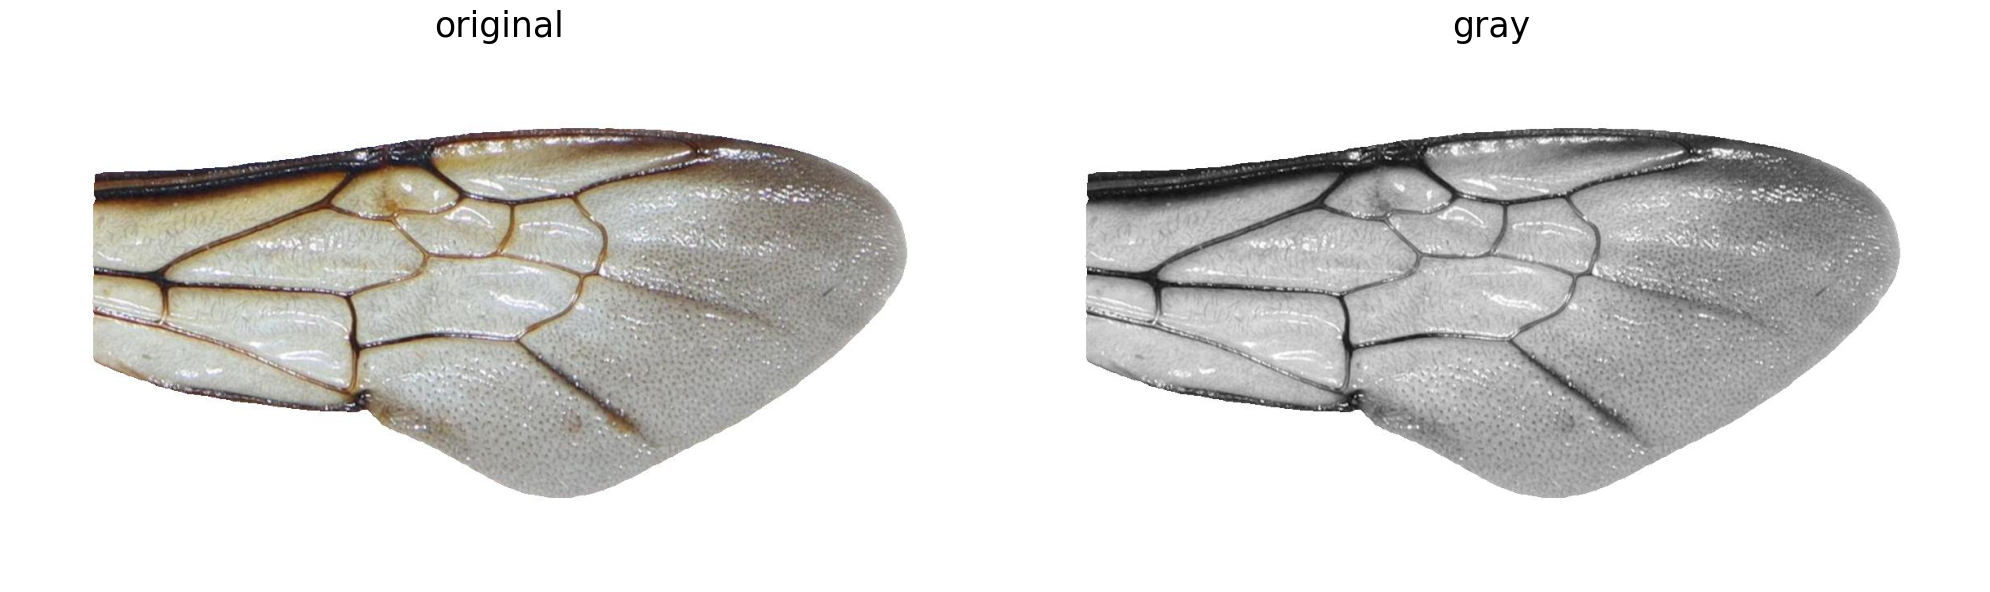

In [5]:
test_1 = "/mnt/c/Projects/Master/Data/Processed/3-LiveWingWingRemovedBackground/Round01-Hive01-2024_06_11-h01b23.JPG"
test_2 = "/mnt/c/Projects/Master/Data/"
test_3 = "/mnt/c/Projects/Master/Data/"

# Load image
image = cv2.imread(test_1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a 1x2 figure
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# Image 1
axes[0].imshow(image)
axes[0].axis("off")
axes[0].set_title("original", size=25)

# Grayscale image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Image 1
axes[1].imshow(gray, cmap="gray")
axes[1].axis("off")
axes[1].set_title("gray", size=25)

# Show the figure
plt.tight_layout()
plt.show()

blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

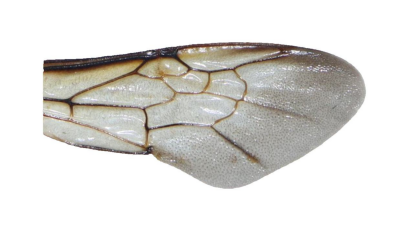

In [6]:
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()


Best threshold: 168
  Number of segments: 16
  Percentage of area covered: 20.83%
  Centroids: [(668, 524), (795, 439), (859, 429), (561, 416), (227, 389), (295, 344), (722, 350), (559, 313), (369, 260), (669, 237), (550, 226), (213, 226), (431, 191), (792, 221), (506, 182), (650, 163)]


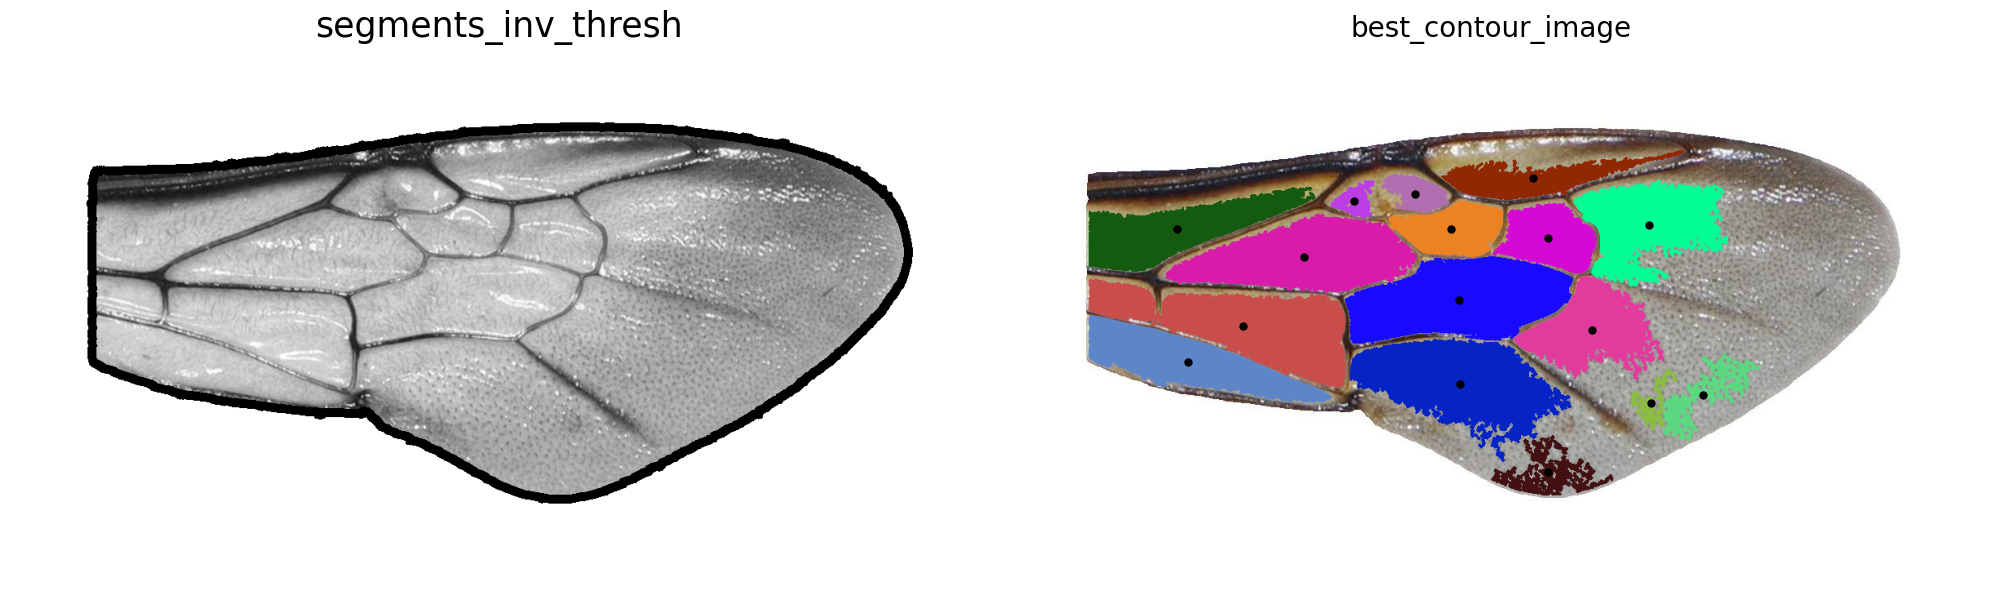

In [15]:
def segmentation(gray, image):
    # Apply Gaussian Blur
    blurred_image = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply thresholding to get a binary image
    _, wing_thresh = cv2.threshold(blurred_image, 250, 255, cv2.THRESH_BINARY)

    # Invert the binary image
    wing_inv_thresh = cv2.bitwise_not(wing_thresh)

    # Find contour
    all_wing_contours, _ = cv2.findContours(wing_inv_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate wing area
    wing_area = sum(cv2.contourArea(contour) for contour in all_wing_contours)
    
    wing_contour_image = gray.copy()
    cv2.drawContours(wing_contour_image, all_wing_contours, -1, (0), 10)
    """
    plt.figure(figsize=(20, 20))
    plt.imshow(wing_contour_image, cmap="gray")
    plt.axis("off")
    plt.show() 
    """
    # Initialize variables to track the best image
    max_contours = 0
    best_percentage_covered = 0
    best_centroids = []
    best_contour_image = None
    best_threshold = None

    threshold = 250
    while threshold >= 0:
        # Apply thresholding to get a binary image
        _, segments_thresh = cv2.threshold(wing_contour_image, threshold, 255, cv2.THRESH_BINARY)
    
        # Invert the binary image
        segments_inv_thresh = cv2.bitwise_not(segments_thresh)
        
        # Find contour
        # all_segments_contours, _ = cv2.findContours(segments_inv_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
        # Find contours with RETR_TREE to get hierarchy
        all_segments_contours, hierarchy = cv2.findContours(segments_inv_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
        # Filter only internal contours
        internal_contours = [all_segments_contours[i] for i in range(len(all_segments_contours)) if hierarchy[0][i][3] != -1]

        # Filter out small contours
        large_segment_contours = [cnt for cnt in internal_contours if (cv2.contourArea(cnt) > 1000)]

        if len(large_segment_contours) > 0:
            # Initialize total area and centroids
            total_area = 0
            centroids = []
    
            # Create a copy of the image for drawing
            segments_contour_image = image.copy()
    
            # Process each contour
            for contour in large_segment_contours:
                # Calculate area
                contour_area = cv2.contourArea(contour)
                total_area += contour_area
    
                # Calculate centroid
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    centroids.append((cx, cy))
    
                    # Draw a small circle at the center
                    # cv2.circle(segments_contour_image, (cx, cy), radius=5, color=(0, 0, 0), thickness=-1)
    
                # Draw the contour
                color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
                cv2.drawContours(segments_contour_image, [contour], -1, color, thickness=cv2.FILLED)
    
            # Calculate percentage covered
            wing_area = gray.shape[0] * gray.shape[1]
            percentage_covered = (total_area / wing_area) * 100
    
            # print(f"  Number of segments: {len(large_segment_contours)}")
            # print(f"  Percentage of area covered: {percentage_covered:.2f}%")
    
            # Update the best image based on criteria
            if (len(large_segment_contours) > max_contours) or (len(large_segment_contours) == max_contours and percentage_covered > best_percentage_covered):
                best_threshold = threshold
                max_contours = len(large_segment_contours)
                best_percentage_covered = percentage_covered
                best_centroids = centroids
                best_contour_image = segments_contour_image

        # Decrease threshold until 0 is reached 
        threshold -= 1

    # Output the results for the best image
    print(f"\nBest threshold: {best_threshold}")
    print(f"  Number of segments: {max_contours}")
    print(f"  Percentage of area covered: {best_percentage_covered:.2f}%")
    print(f"  Centroids: {best_centroids}")

    # Extract X and Y coordinates of centroids
    centroid_x = [cx for cx, cy in best_centroids]
    centroid_y = [cy for cx, cy in best_centroids]

    # Create a 1x2 figure
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    # Image 1
    axes[0].imshow(wing_contour_image, cmap="gray")
    axes[0].axis("off")
    axes[0].set_title(f"segments_inv_thresh", size=25)
    # Image 2
    axes[1].imshow(best_contour_image)
    axes[1].scatter(centroid_x, centroid_y, c="black", s=100, marker=".")
    axes[1].set_title(f"best_contour_image", size=20)
    axes[1].axis("off")

    # Show the figure
    plt.tight_layout()
    plt.show()
    plt.close()
    
segmentation(gray, image)

Processing file 001/189:	Round01-Hive01-2024_06_05-h01bee01.JPG

Best threshold: 75
  Number of segments: 12
  Percentage of area covered: 9.71%
  Centroids: [(169, 414), (266, 410), (414, 408), (564, 346), (597, 301), (442, 324), (354, 277), (421, 244), (378, 214), (525, 239), (638, 208), (482, 176)]


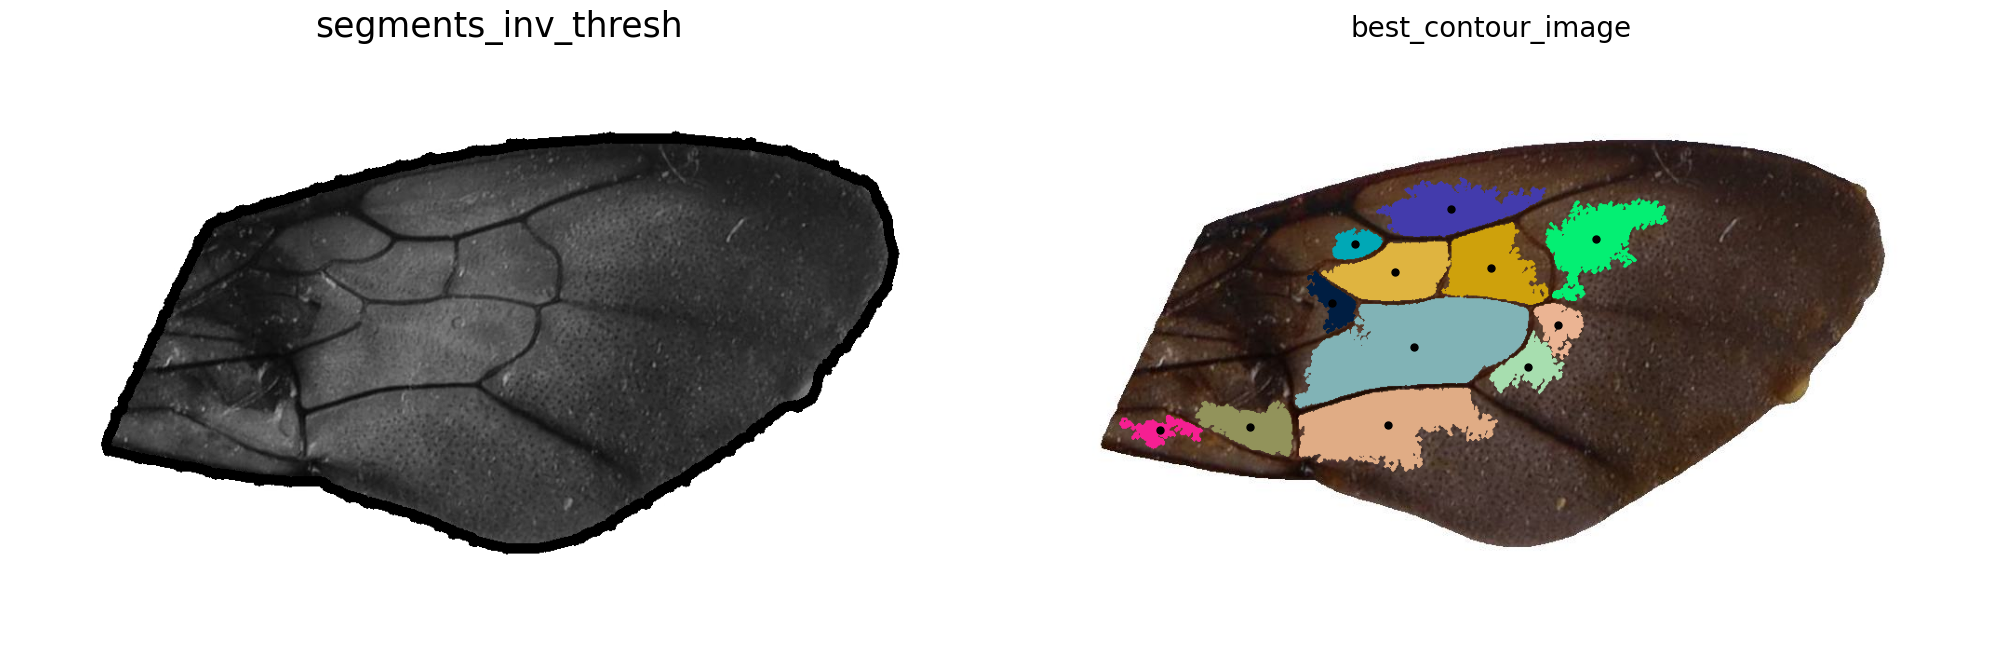

Processing file 002/189:	Round01-Hive01-2024_06_05-h01bee16.JPG

Best threshold: 67
  Number of segments: 15
  Percentage of area covered: 26.58%
  Centroids: [(167, 365), (173, 306), (147, 234), (464, 232), (334, 199), (509, 346), (459, 405), (738, 335), (605, 320), (253, 198), (200, 218), (245, 165), (131, 162), (305, 167), (472, 152)]


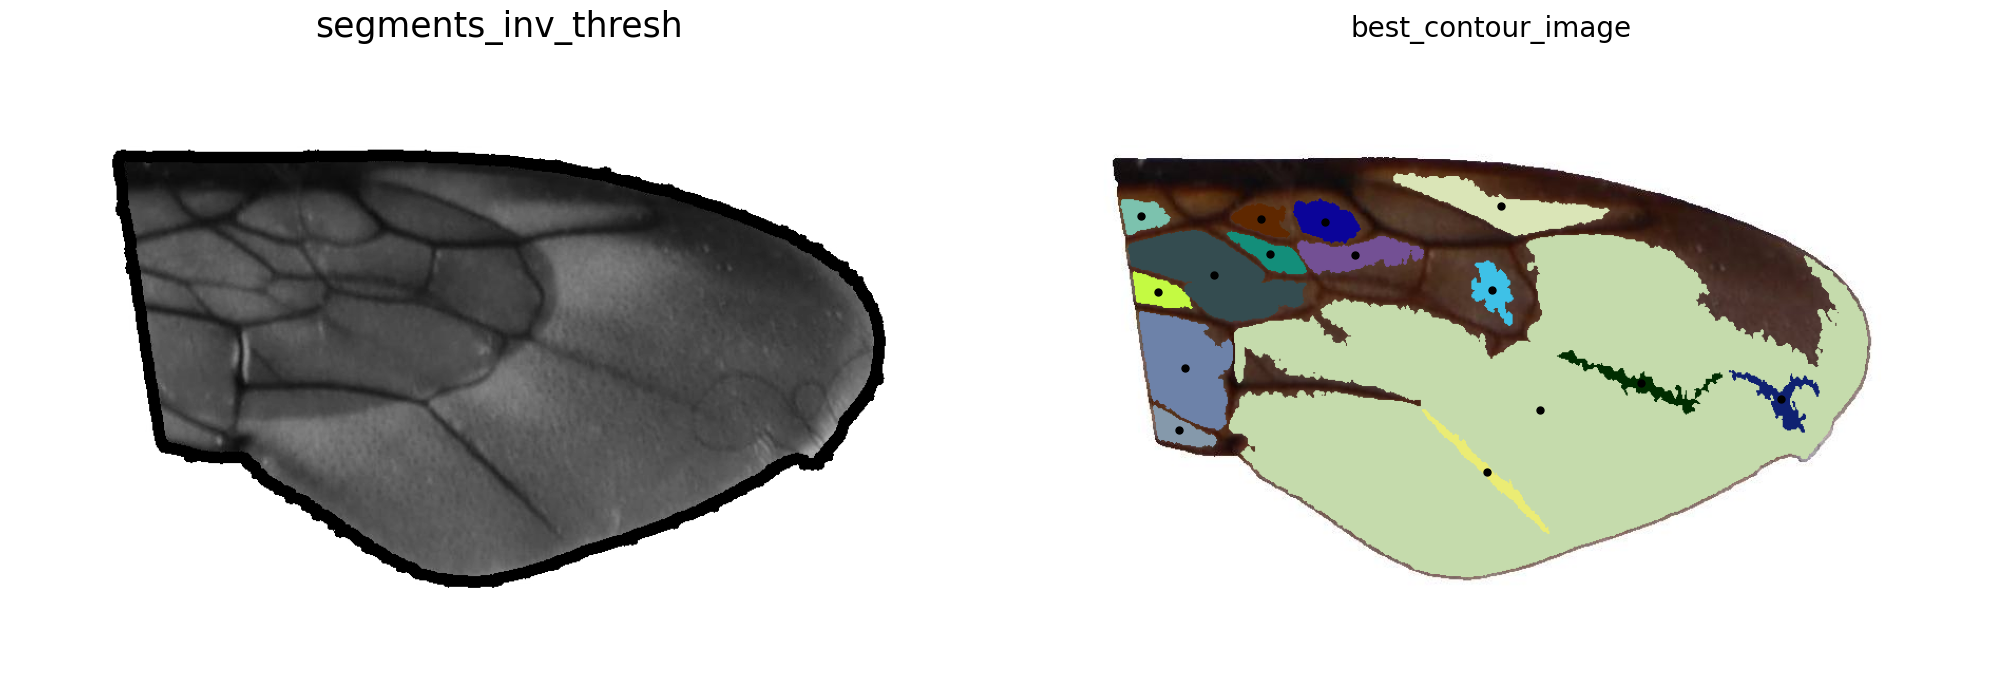

Processing file 003/189:	Round01-Hive01-2024_06_05-h01bee19.JPG

Best threshold: 103
  Number of segments: 8
  Percentage of area covered: 10.01%
  Centroids: [(258, 478), (179, 365), (294, 301), (185, 270), (158, 193), (254, 200), (349, 170), (174, 136)]


KeyboardInterrupt: 

In [19]:
# Define directories
input_dir = "/mnt/c/Projects/Master/Data/Processed/3-LiveWingWingRemovedBackground_1/"
output_dir = "/mnt/c/Projects/Master/Data/Testdata/4-LiveWingSegmented/"

# Find all jpg files
jpg_files = []
for root, _, files in os.walk(input_dir):
    for file in files:
        if file.endswith(".JPG") or file.endswith(".jpg"):
            jpg_files.append(os.path.join(root, file))

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Process every file
total_files = len(jpg_files)
digits = len(str(total_files))
for idx, jpg_file_path in enumerate(jpg_files, 1):
    jpg_basename = os.path.basename(jpg_file_path)
    output_file = output_dir + jpg_basename
    relative_jpg_path = jpg_file_path.removeprefix(input_dir)
    print(f"Processing file {idx:0{digits}}/{total_files}:\t{relative_jpg_path}")
    
    # Load image
    image = cv2.imread(jpg_file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    segmentation(gray, image)